## Plot results

The purpose of this notebook is to visualize models' performances singlehandedly and/or with respect to each other's. It expects the selected models to have already gone through training using the `run_exp_script.py` script.

In [265]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from models.double_branch import DoubleBranchCNN
from utils import plot_utils as plot
from utils import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Train/Val Plot

In [266]:
RESULT_PATH = 'models/results/rn18_ms_e2e_l7_yeh.pkl'
# Load Results
with open(RESULT_PATH, 'rb') as f:
    results = pickle.load(f)

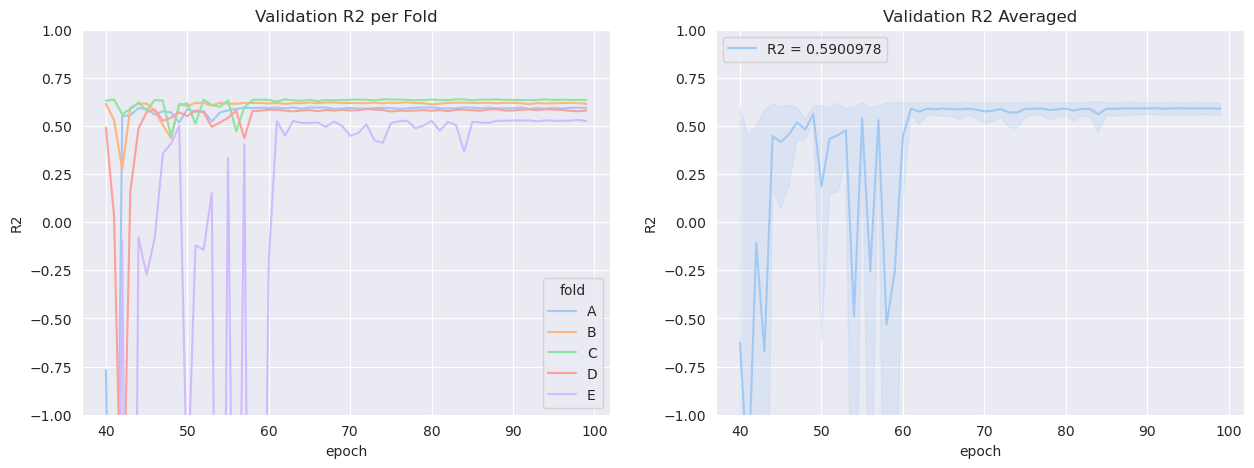

In [267]:
multi_val_dict = plot.extract_crossval_results(results=results, var='test_r2', new_var="R2")
df = pd.DataFrame.from_dict(multi_val_dict)
df=df[df.epoch >= 40] # skip unstable first epochs
# Figures
sns.set_palette('pastel')
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].set_title('Validation R2 per Fold')
ax[1].set_title('Validation R2 Averaged')
sns.lineplot(ax=ax[0], data=df, x="epoch", y="R2", hue="fold", palette="pastel").set(ylim=(-1, 1))
sns.lineplot(ax=ax[1], data=df, x="epoch", y="R2", legend=False).set(ylim=(-1,1.))

# Add R2 value
df2 = df[df['epoch']==df['epoch'].max()]
ax[1].legend(title='', loc='upper left', labels=['R2 = '+str(df2.R2.mean())])


### Test Plots

In [268]:
import geopandas as gpd
import pandas as pd
from sklearn.metrics import r2_score
import test
network_config_filename='configs/resnet18_ms_e2e_l7_yeh.json'
data_config_filename='configs/default_config.pkl'
save_path='results/ms.pkl'
with open('data/dhs_incountry_folds.pkl','rb') as f:
    fold_dict = pickle.load(f)

In [269]:
df_test = test.main(
    write_path=save_path,
    data_config_filename=data_config_filename,
    network_config_filename=network_config_filename,
    dataset=pd.read_csv('data/dataset.csv')
)
r2_all = r2_score(df_test['wealthpooled'], df_test['predicted_wealth'])

Text(1.8, 1.8, 'R2 = 0.4935')

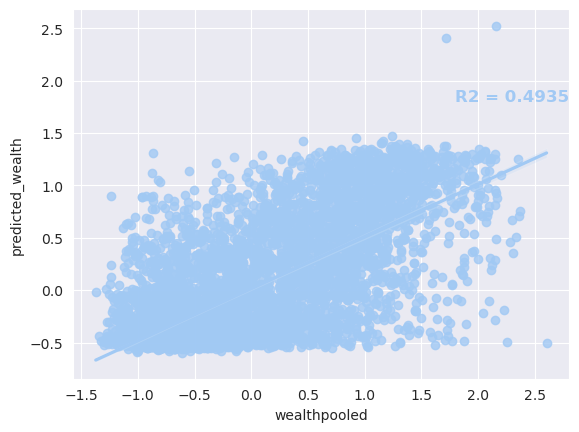

In [320]:
sns.regplot(x="wealthpooled", y="predicted_wealth", data=df_test);
plt.text(1.8,1.8, 'R2 = ' + str(round(r2_all,4)), fontsize='large', weight='bold', color=sns.color_palette().as_hex()[0])

**Countrywise**

In [271]:
df_test['country'] = df_test['country'].apply(utils.standardize_countryname)
df_test = df_test.rename({'country':'ADM0_NAME'},axis='columns')
# Compute Average R2 per Country
country_wise = pd.DataFrame()
country_wise['ADM0_NAME'] = df_test['ADM0_NAME'].unique()
for country in country_wise.ADM0_NAME.unique():
    r2 = r2_score(df_test[df_test.ADM0_NAME==country]['wealthpooled'], df_test[df_test.ADM0_NAME==country]['predicted_wealth'])
    country_wise.loc[country_wise['ADM0_NAME'] == country, ["R2"]] = r2

In [272]:
africa = gpd.read_file('data/africa.json')

In [ ]:
def country_plot(
        data:pd.DataFrame,
        cmap:str,
        bg_color:str,
        edgecolor:str
):
    data['country'] = data['country'].apply(utils.standardize_countryname)
    data = data.rename({'country':'ADM0_NAME'},axis='columns')
    # Compute Average R2 per Country
    country_wise = pd.DataFrame()
    country_wise['ADM0_NAME'] = data['ADM0_NAME'].unique()
    for country in country_wise.ADM0_NAME.unique():
        r2 = r2_score(data[data.ADM0_NAME==country]['wealthpooled'], data[data.ADM0_NAME==country]['predicted_wealth'])
        country_wise.loc[country_wise['ADM0_NAME'] == country, ["R2"]] = r2
    base = africa.plot(color=bg_color, edgecolor=edgecolor)
    base.set_axis_off()
    countryplot = africa.merge(country_wise, on='ADM0_NAME', how='left')
    countryplot.plot(
        column='R2', 
        scheme="quantiles",
        k=12,
        edgecolor="k",
        ax=base, 
        legend=True, 
        cmap=cmap,
        figsize=(50,50),
        legend_kwds={'loc': 'lower left', "fontsize":"8"}
        )

<Axes: >

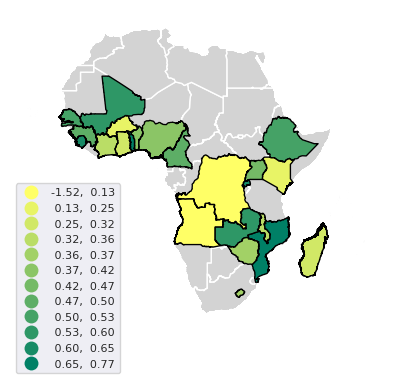

In [316]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth'))
# base = world[world.continent == 'Africa'].plot(color='lightgray', edgecolor='black')
# base.set_axis_off()
base = africa.plot(color='lightgray', edgecolor='white')
base.set_axis_off()
countryplot = africa.merge(country_wise, on='ADM0_NAME', how='left')
countryplot.plot(
    column='R2', 
    scheme="quantiles",
    k=12,
    edgecolor="k",
    ax=base, 
    legend=True, 
    cmap='summer_r',
    figsize=(50,50),
    legend_kwds={'loc': 'lower left', "fontsize":"8"}
    )

**Year Difference**

Text(2.0, 0.2, 'R2 = 0.455')

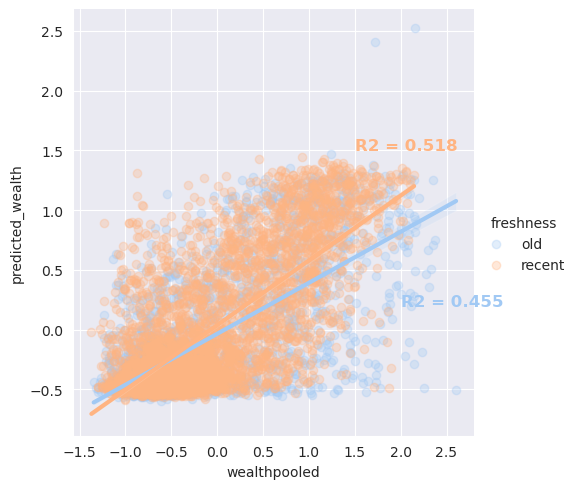

In [333]:
plot.split_regplot(
    data=df_test,
    col_to_split='year',
    newcol_name='Data Freshness',
    split_val=df_test.year.median(),
    labelinf='Old',
    labelsup='Recent',
    scatter_kws={'alpha':0.3},
    line_kws= {'alpha':1., 'linewidth':3}
    )

**Urban vs. Rural**

In [382]:
df_test_ur = df_test[df_test['urban_rural']!=-1]
df_test_ur = df_test_ur.rename({'urban_rural':'Urban vs Rural'},axis=1)
plot.split_regplot(
    data=df_test_ur,
    col_to_split='Urban vs Rural',
    newcol_name='Urban vs Rural',
    split_val=1.,
    labelinf='Rural',
    labelsup='Urban',
    scatter_kws={'alpha':0.3},
    line_kws= {'alpha':1., 'linewidth':3}
    )

### Multi Model Plot